# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [17]:
# TODO: Import required libraries and modules

import warnings as warn
import time as timer
import logging as log
import json 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator as ImgGen

# Suppress warnings and irrelevant TensorFlow logs
warn.filterwarnings('ignore')
tfds.disable_progress_bar()


## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [8]:
# TODO: Load dataset using TensorFlow Datasets
data, data_info = tfds.load(
    'oxford_flowers102',
    as_supervised=True,
    with_info=True
)

# TODO: Split dataset into training, validation, and test sets
train_data = data['train']
val_data = data['validation']
test_data = data['test']


## Explore the Dataset

In [9]:
# TODO: Retrieve the number of examples in each split from the dataset information
split_names = ['train', 'test', 'validation']
for split in split_names:
    print(f'The {split} split contains {data_info.splits[split].num_examples} examples')

total_examples = data_info.splits['train'].num_examples

# TODO: Retrieve the number of classes from the dataset information
class_count = data_info.features['label'].num_classes
print(f"Total Number of Classes: {class_count}")


The train split contains 1020 examples
The test split contains 6149 examples
The validation split contains 1020 examples
Total Number of Classes: 102


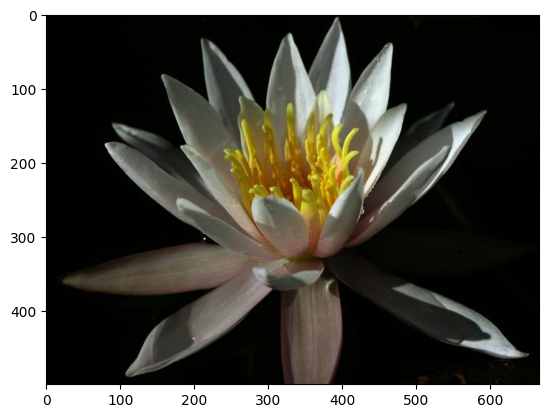

The shape of this image is: (500, 667, 3)
The label of this image is: 72


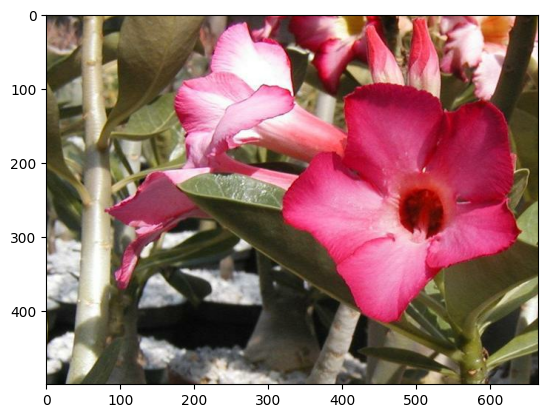

The shape of this image is: (500, 666, 3)
The label of this image is: 84


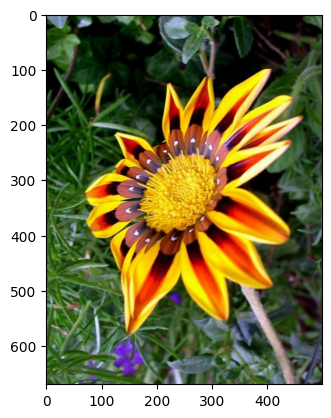

The shape of this image is: (670, 500, 3)
The label of this image is: 70


In [10]:
# TODO: Display the shape and corresponding label of 3 images from the training data
for img, lbl in train_data.take(3):
    img = img.numpy()
    lbl = lbl.numpy()

    plt.imshow(img)
    plt.show()

    print(f'The shape of this image is: {img.shape}')
    print(f'The label of this image is: {lbl}')


Text(0.5, 1.0, 'Label: 72')

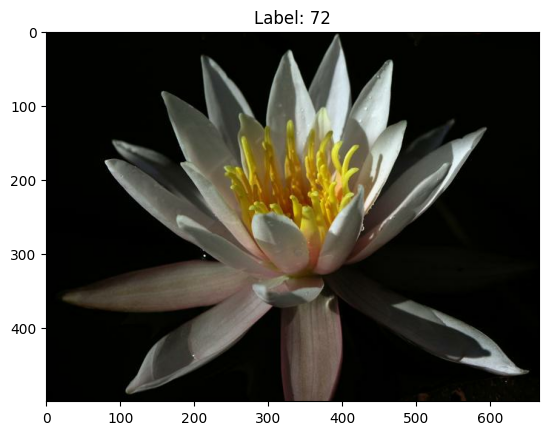

In [11]:
# TODO: Display a single image from the training data with its label as the title
for img, lbl in train_data.take(1):
    img = img.numpy()
    lbl = lbl.numpy()

plt.imshow(img)
plt.title(f'Label: {lbl}')


### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [12]:
# TODO: Load and display the class names from the label map
with open('label_map.json', 'r') as file:
    class_labels = json.load(file)

print(json.dumps(class_labels, indent=4))


{
    "0": "pink primrose",
    "1": "hard-leaved pocket orchid",
    "2": "canterbury bells",
    "3": "sweet pea",
    "4": "english marigold",
    "5": "tiger lily",
    "6": "moon orchid",
    "7": "bird of paradise",
    "8": "monkshood",
    "9": "globe thistle",
    "10": "snapdragon",
    "11": "colt's foot",
    "12": "king protea",
    "13": "spear thistle",
    "14": "yellow iris",
    "15": "globe-flower",
    "16": "purple coneflower",
    "17": "peruvian lily",
    "18": "balloon flower",
    "19": "giant white arum lily",
    "20": "fire lily",
    "21": "pincushion flower",
    "22": "fritillary",
    "23": "red ginger",
    "24": "grape hyacinth",
    "25": "corn poppy",
    "26": "prince of wales feathers",
    "27": "stemless gentian",
    "28": "artichoke",
    "29": "sweet william",
    "30": "carnation",
    "31": "garden phlox",
    "32": "love in the mist",
    "33": "mexican aster",
    "34": "alpine sea holly",
    "35": "ruby-lipped cattleya",
    "36": "cape

In [13]:
# TODO: Display a label batch from the training dataset
for img_batch, lbl_batch in train_data.take(1):  # Take 1 batch
    print(f"Batch labels: {lbl_batch}")
    break


Batch labels: 72


Text(0.5, 1.0, 'water lily')

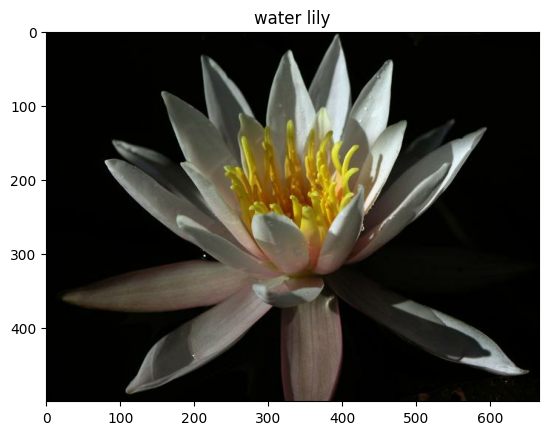

In [14]:
# TODO: Display a single image with its class name as the title
for img, lbl in train_data.take(1):
    img = img.numpy()
    lbl = lbl.numpy()

plt.imshow(img)
plt.title(class_labels[str(lbl)])


## Create Pipeline

In [15]:
# TODO: Build a data pipeline for each dataset split

batch_size = 32
img_size = 224
train_percentage = 60

num_train_samples = (total_examples * train_percentage) // 100

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (img_size, img_size))
    image /= 255
    return image, label


train_pipeline = train_data.shuffle(num_train_samples // 4).map(preprocess_image).batch(batch_size).prefetch(1)
val_pipeline = val_data.map(preprocess_image).batch(batch_size).prefetch(1)
test_pipeline = test_data.map(preprocess_image).batch(batch_size).prefetch(1)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [18]:
# TODO: Construct and train the model

model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(model_url, input_shape=(img_size, img_size, 3))
feature_extractor_layer.trainable = False

model_architecture = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(class_count, activation='softmax')
])

model_architecture.summary()
print(f'GPU Available: {tf.test.is_gpu_available()}')

model_architecture.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

epochs_count = 5

training_history = model_architecture.fit(train_pipeline,
                                          epochs=epochs_count,
                                          validation_data=val_pipeline)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
Epoch 1/5
32/32 [==============================] - 139s 4s/step - loss: 4.2959 - accuracy: 0.1039 - val_loss: 3.1342 - val_accuracy: 0.3549
Epoch 2/5
32/32 [==============================] - 125s 4s/step - loss: 2.0942 - accuracy: 0.6951 - val_loss: 2.0321 - val_accuracy: 0.6324
Epoch 3/5
32/32 [==============================] - 115s 4s/step - loss: 1.1069 - accuracy: 0.8980 - val_loss: 1.5478 - val_accuracy: 0.7304
Epoch 4/5
32/32 [==============================] - 112s 4s/step - loss: 0.6714 - accuracy: 0.9569 - val_loss: 1.3134 - val_accuracy: 0.7696
Epoch 5/5
32/32 [==============================] - 114s 4s/step - loss: 0.4441 - accuracy: 0.9863 - val_loss: 1.1695 - val_accuracy: 0.7863


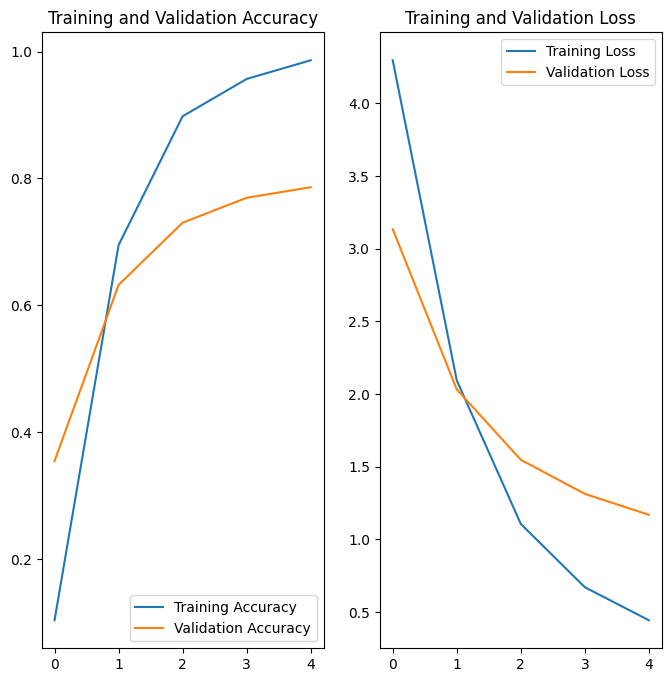

In [19]:
# TODO: Visualize training and validation loss and accuracy over epochs

train_accuracy = training_history.history['accuracy']
val_accuracy = training_history.history['val_accuracy']

train_loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs_range = range(epochs_count)

plt.figure(figsize=(8, 8))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [20]:
# TODO: Evaluate and print the performance on the test set

test_loss, test_accuracy = model_architecture.evaluate(test_pipeline)

print(f'\nTest Set Loss: {test_loss:,.3f}')
print(f'Test Set Accuracy: {test_accuracy:.3%}')


193/193 [==============================] - 338s 2s/step - loss: 1.2794 - accuracy: 0.7409

Test Set Loss: 1.279
Test Set Accuracy: 74.093%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [21]:
# TODO: Save the trained model as a Keras model

model_save_path = './my_trained_model.h5'

# Saving the model
model_architecture.save(model_save_path)


## Load the Keras Model

Load the Keras model you saved above.

In [23]:
# TODO: Load the Keras model

reloaded_keras_model = tf.keras.models.load_model(model_save_path, custom_objects={'KerasLayer': hub.KerasLayer})

reloaded_keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [26]:
# TODO: Create the process_image function
image_size = 224
def process_image(image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
#     image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image.numpy()

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

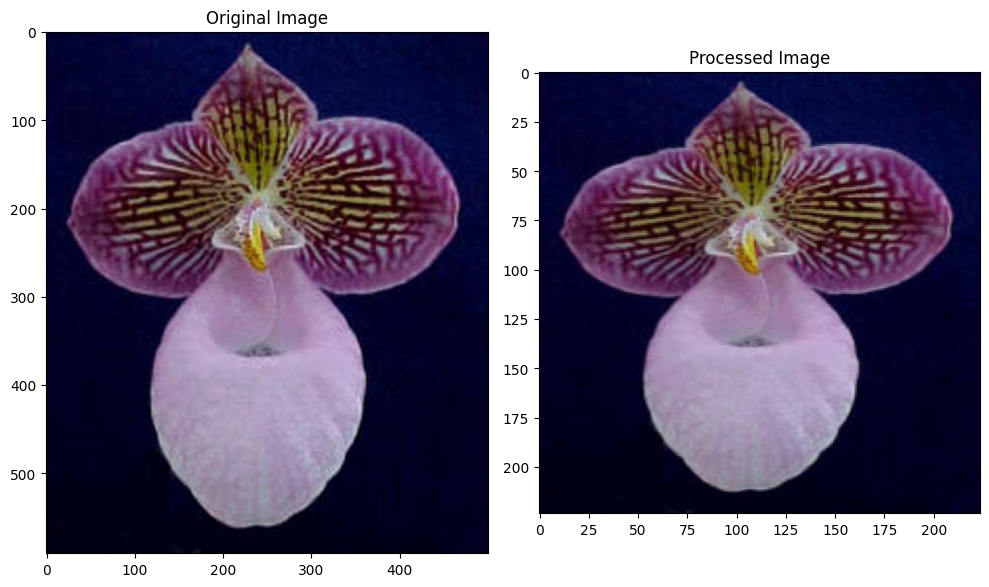

In [27]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension. 

In [28]:
# TODO: Create the predict function

def predict(image_path, model, top_k):
    if top_k < 1:
        top_k = 1
    image = Image.open(image_path)
    image = np.asarray(image)
    image = process_image(image)
    expanded_image = np.expand_dims(image, axis=0)
    probes = reloaded_keras_model.predict(expanded_image)
    top_k_values, top_k_indices = tf.nn.top_k(probes, k=top_k)
    
    top_k_values = top_k_values.numpy()
    top_k_indices = top_k_indices.numpy()
    
    
    return top_k_values, top_k_indices, image

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

1/1 [==============================] - 0s 48ms/step
Propabilties: [[0.6287422  0.07829425 0.03110686 0.02375889 0.01892385]]
Classes Keys: [[60 23 45 10 38]]
Classes Values:
- japanese anemone
- grape hyacinth
- marigold
- colt's foot
- lenten rose


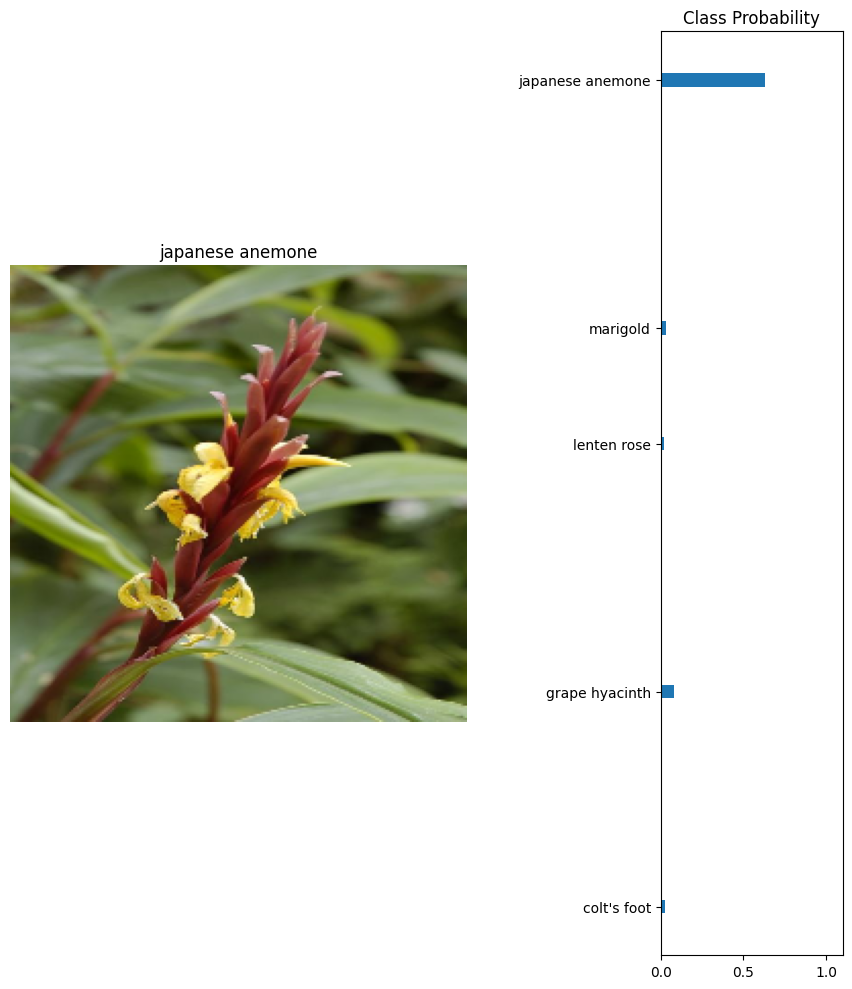

1/1 [==============================] - 0s 68ms/step
Propabilties: [[0.9779724  0.00294204 0.00276943 0.00193046 0.00164317]]
Classes Keys: [[ 1 67  5 79  6]]
Classes Values:
- canterbury bells
- windflower
- moon orchid
- frangipani
- bird of paradise


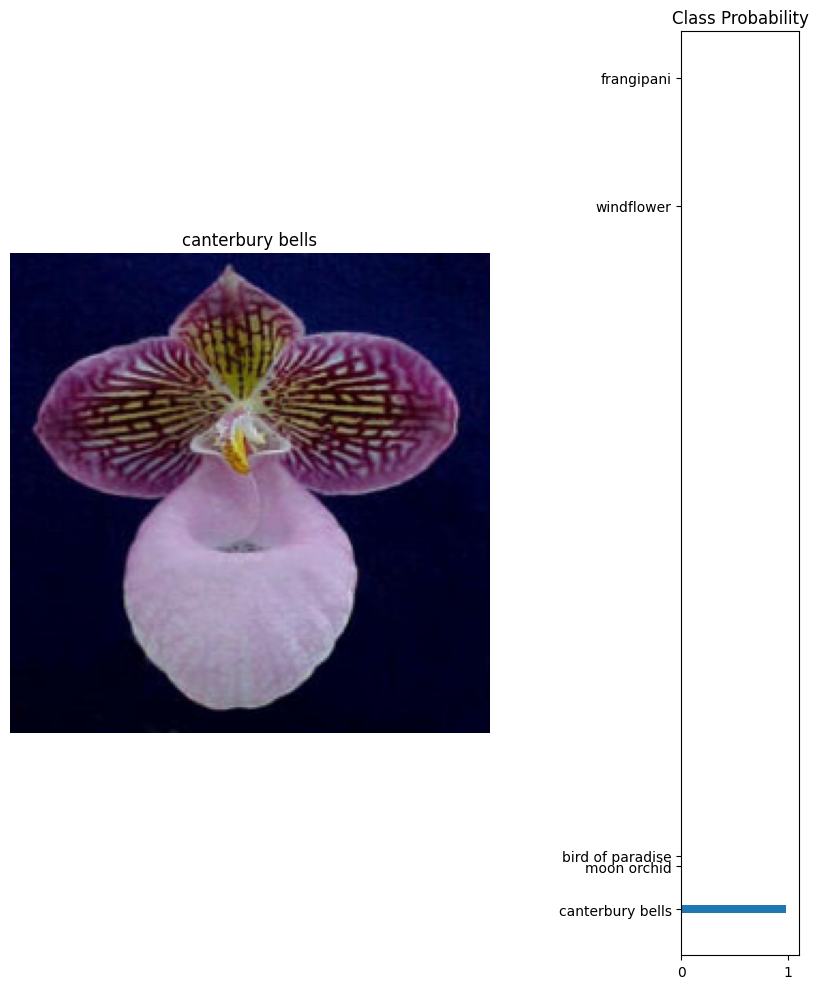

1/1 [==============================] - 0s 34ms/step
Propabilties: [[0.24919108 0.10456977 0.08895214 0.07403275 0.04968654]]
Classes Keys: [[58  4 65 99 40]]
Classes Values:
- pink-yellow dahlia?
- tiger lily
- spring crocus
- trumpet creeper
- daffodil


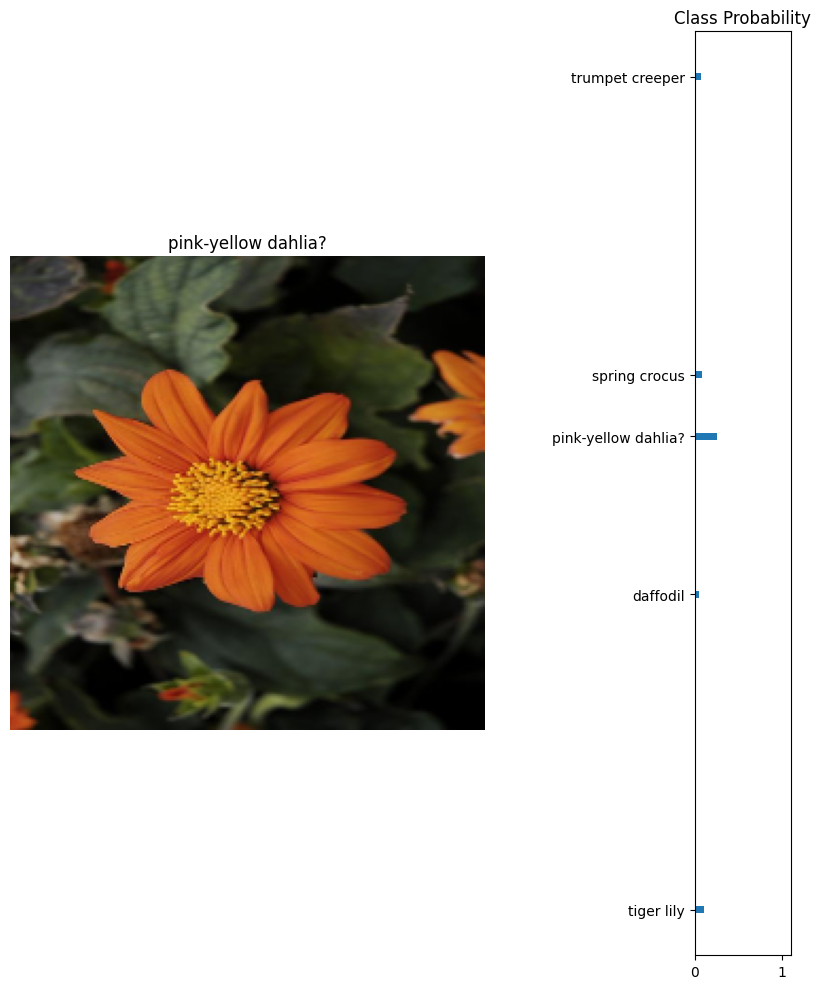

1/1 [==============================] - 0s 37ms/step
Propabilties: [[0.9085587  0.01191525 0.01070172 0.01000486 0.00933732]]
Classes Keys: [[51 18 33 63 68]]
Classes Values:
- primula
- giant white arum lily
- alpine sea holly
- californian poppy
- tree poppy


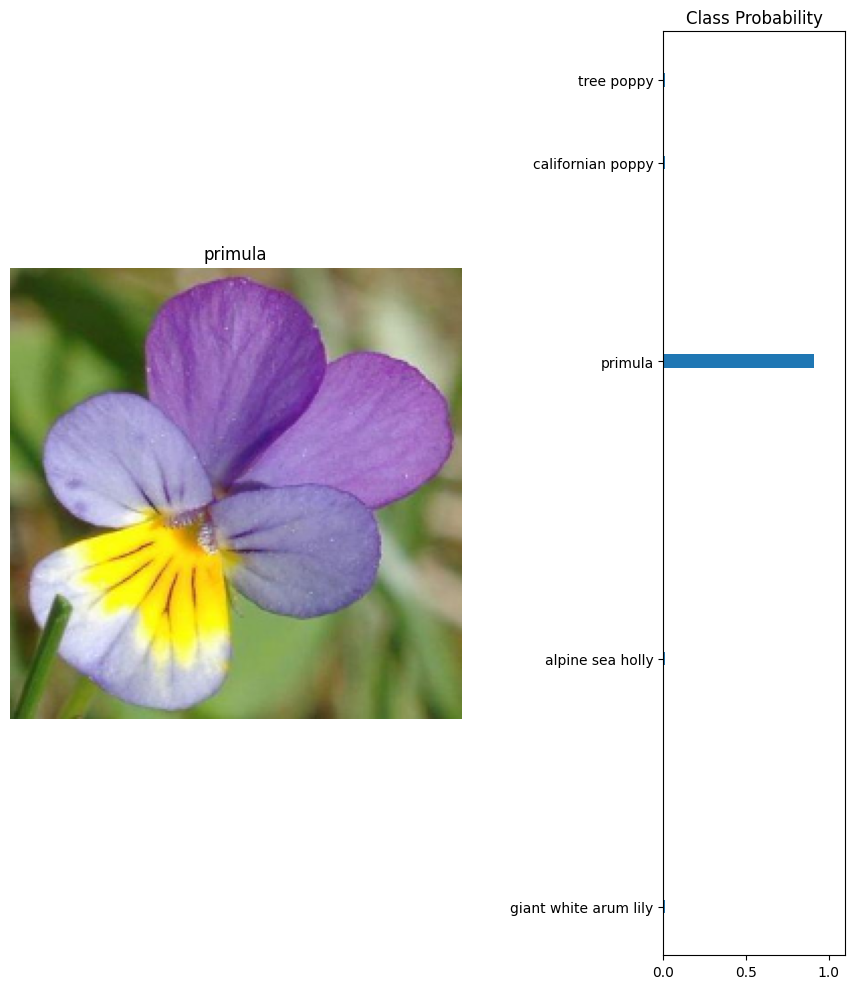

In [31]:
# TODO: Plot the input image along with the top 5 classes

images = ['cautleya_spicata.jpg', 'hard-leaved_pocket_orchid.jpg', 'orange_dahlia.jpg', 'wild_pansy.jpg']

for img in images:
    url = './test_images/{}'.format(img)
    top_k_values, top_k_indices, image = predict(url, reloaded_keras_model, 5)
    print('Propabilties:', top_k_values)
    print('Classes Keys:', top_k_indices)
    
    flower_classes = []
    print("Classes Values:")
    for idx in top_k_indices[0]:
        print("-",class_labels[str(idx+1)])
        flower_classes.append(class_labels[str(idx+1)])
        
    fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(flower_classes[0])
    ax2.barh(top_k_indices[0], top_k_values[0])
    ax2.set_aspect(0.1)
    ax2.set_yticks(top_k_indices[0])
    ax2.set_yticklabels(flower_classes);
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()